In [1]:
#Setting up connection with the database
import psycopg2
from getpass import getpass

# =================================
# == Database connection details ==
#==================================
host = '10.158.72.123' 
dbname = 'nlab' 
username = 'lixsn25' 
password = '@qxazPHG0' 
schema = 'ml17' 
# =================================

In [2]:
#Loading relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import svm
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error
import datetime
from datetime import timedelta
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from boruta import BorutaPy
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

C:\Users\Sannia\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Sannia\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Sannia\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed

# Feature Engineering

FEATURES MADE FROM VISITS, QUANTITIES PURCHASED AND VALUE SPENT

In [74]:
#Retrieving data using SQL
#This set of command makes variables f1-f12 
#f1-f4 are the number if visits of customers
#f5-f8 are the quantities bought by customers
#f9-f12 are the value of items bought

def get_dataset1( reference_day = '2019-10-29', tumbling_window_size = 7, output_window_size = 21 ):
    sql = """
    SELECT customer_id, ref_day, output_feature, f1, f2, f3, f4, f5, f6, f7, f8,f9,f10,f11,f12
    FROM(
        SELECT customer_id,
           %(ref_date)s::DATE AS ref_day,
           SUM( DISTINCT CASE WHEN purchased_at > %(ref_date)s::DATE AND purchased_at <= %(ref_date)s::DATE + %(ows)s::INT THEN 1 ELSE 0 END) as output_feature,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT AND purchased_at <= %(ref_date)s::DATE THEN 1 ELSE 0 END ) as f1,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*2 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT THEN 1 ELSE 0 END ) as f2,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*3 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*2 THEN 1 ELSE 0 END ) as f3,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*4 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*3 THEN 1 ELSE 0 END ) as f4,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT AND purchased_at <= %(ref_date)s::DATE THEN qty ELSE 0 END ) as f5,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*2 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT THEN qty ELSE 0 END ) as f6,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*3 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*2 THEN qty ELSE 0 END ) as f7,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*4 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*3 THEN qty ELSE 0 END ) as f8,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT AND purchased_at <= %(ref_date)s::DATE THEN value ELSE 0 END ) as f9,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*2 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT THEN value ELSE 0 END ) as f10,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*3 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*2 THEN value ELSE 0 END ) as f11,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*4 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*3 THEN value ELSE 0 END ) as f12
        FROM data
        GROUP BY 1
        ORDER BY 1
        ) X
    WHERE f1 > 0 or f2>0 or f3>0
    """
    with psycopg2.connect("host='{}' dbname='nlab' user='{}' password='{}'".format(host, username, password)) as conn:
        df = pd.read_sql(sql, conn, params = {'ref_date':reference_day, 'ws':tumbling_window_size, 'ows':output_window_size})

    return df.drop(columns = ['ref_day','output_feature', 'customer_id'], inplace = False), df.output_feature

FEATURES MADE FROM VISITS AND QUANTITY ONLY 

In [75]:
#This set of command makes variables f1-f8 
#f1-f4 are the number if visits of customers
#f5-f8 are the quantities bought by customers
def get_dataset( reference_day = '2019-10-29', tumbling_window_size = 7, output_window_size = 21 ):
    sql = """
    SELECT customer_id, ref_day, output_feature, f1, f2, f3, f4, f5, f6, f7, f8
    FROM(
        SELECT customer_id,
           %(ref_date)s::DATE AS ref_day,
           SUM( DISTINCT CASE WHEN purchased_at > %(ref_date)s::DATE AND purchased_at <= %(ref_date)s::DATE + %(ows)s::INT THEN 1 ELSE 0 END) as output_feature,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT AND purchased_at <= %(ref_date)s::DATE THEN 1 ELSE 0 END ) as f1,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*2 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT THEN 1 ELSE 0 END ) as f2,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*3 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*2 THEN 1 ELSE 0 END ) as f3,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*4 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*3 THEN 1 ELSE 0 END ) as f4,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT AND purchased_at <= %(ref_date)s::DATE THEN qty ELSE 0 END ) as f5,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*2 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT THEN qty ELSE 0 END ) as f6,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*3 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*2 THEN qty ELSE 0 END ) as f7,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*4 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*3 THEN qty ELSE 0 END ) as f8
    FROM data
    GROUP BY 1
    ORDER BY 1) X
    WHERE f1 > 0 or f2>0 or f3>0
    """
    with psycopg2.connect("host='{}' dbname='nlab' user='{}' password='{}'".format(host, username, password)) as conn:
        df = pd.read_sql(sql, conn, params = {'ref_date':reference_day, 'ws':tumbling_window_size, 'ows':output_window_size})

    return df.drop(columns = ['ref_day','output_feature', 'customer_id'], inplace = False), df.output_feature

# Feature Selection

In [76]:
#converting to dataframe
tumbling_window_size= 7
output_window_size= 21
a= get_dataset1( '2019-10-29' , tumbling_window_size, output_window_size )
df1 = a[0].assign(churn=a[1])

#checking correlation of variables
df1.corr()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,churn
f1,1.000000,0.385306,0.458550,0.497579,0.674713,0.182275,0.254392,0.310622,0.639454,0.132800,0.208169,0.299329,0.254070
f2,0.385306,1.000000,0.412212,0.511062,0.246631,0.595545,0.227485,0.309416,0.192491,0.528400,0.169754,0.286537,0.230641
f3,0.458550,0.412212,1.000000,0.533278,0.288646,0.174155,0.648657,0.297511,0.243806,0.110931,0.608137,0.276058,0.256803
f4,0.497579,0.511062,0.533278,1.000000,0.313698,0.255514,0.298045,0.638303,0.274668,0.206514,0.258450,0.642849,0.319971
f5,0.674713,0.246631,0.288646,0.313698,1.000000,0.293931,0.289329,0.388891,0.893041,0.209728,0.223559,0.345664,0.189953
f6,0.182275,0.595545,0.174155,0.255514,0.293931,1.000000,0.231933,0.341061,0.228314,0.795523,0.157018,0.289329,0.149823
f7,0.254392,0.227485,0.648657,0.298045,0.289329,0.231933,1.000000,0.322193,0.233458,0.140717,0.860022,0.288756,0.193903
f8,0.310622,0.309416,0.297511,0.638303,0.388891,0.341061,0.322193,1.000000,0.324752,0.238859,0.258454,0.909690,0.244389
f9,0.639454,0.192491,0.243806,0.274668,0.893041,0.228314,0.233458,0.324752,1.000000,0.207139,0.233899,0.335206,0.186641
f10,0.132800,0.528400,0.110931,0.206514,0.209728,0.795523,0.140717,0.238859,0.207139,1.000000,0.126232,0.250039,0.133032


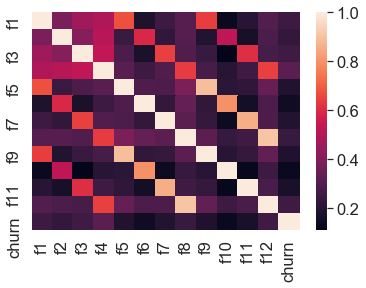

In [101]:
#correlation plot of variables from f1 to f12
sns.heatmap(df1.corr())
plt.show()

In [78]:
#converting to dataframe (using only f1-f8)
tumbling_window_size= 7
output_window_size= 21

a= get_dataset( '2019-10-29' , tumbling_window_size, output_window_size )
df = a[0].assign(churn=a[1])

df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,churn
0,0,1,1,0,0.0,14.0,4.0,0.0,1
1,0,1,0,1,0.0,8.0,0.0,21.0,1
2,0,2,2,0,0.0,18.0,20.0,0.0,1
3,4,2,5,6,38.0,31.0,47.0,82.0,1
4,1,1,1,0,28.0,21.0,28.0,0.0,1


Selected Features:
f5
f6
f7
f8


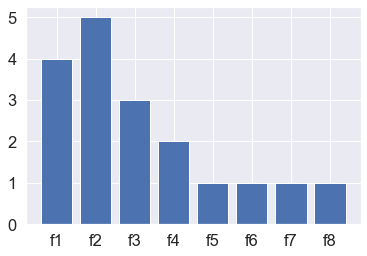

In [79]:
#Choosing top 4 variables
array = df.values
X = array[:,0:-1]
y = array[:,-1]

rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=1), 4 )
fit = rfe.fit(train[0], train[1])
# report selected features
print('Selected Features:')
names = df.columns.values[0:-1]
for i in range(len(fit.support_)):
	if fit.support_[i]:
		print(names[i])
# plot feature rank
names = df.columns.values[0:-1]
ticks = [i for i in range(len(names))]
plt.bar(ticks, fit.ranking_)
plt.xticks(ticks, names)
plt.show()

In [80]:
#using boruta method 

tumbling_window_size=7
output_window_size=21
#defining train and test set
date= datetime.date(2019,11,19)
date1 = datetime.timedelta(days=output_window_size)
date2= date-date1
date3=datetime.timedelta(days=tumbling_window_size*3)
date4=date2-date3

now = datetime.datetime.strftime(date2, "%Y/%m/%d")
now2=datetime.datetime.strftime(date4, "%Y/%m/%d")

test = get_dataset( now , tumbling_window_size, output_window_size )
train = get_dataset( now2, tumbling_window_size, output_window_size )

feat_selector = BorutaPy(RandomForestClassifier(), n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(train[0].values,train[1].values)
print(train[0].columns[feat_selector.support_] )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	0
Rejected: 	8


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	0
Rejected: 	8
Index([], dtype='object')


In [99]:
#comparing boruta selected feature accuracy with all features
rf0 = RandomForestClassifier()

rf0.fit(train[0], train[1].values)

y_pred = rf0.predict(test[0].values)

scores = accuracy_score(test[1], y_pred)

print('Predicting with all features: {}'.format(scores))




Predicting with all features: 0.7340823970037453


In [ ]:
X_train_red = feat_selector.transform(train[0].values)

rf1 = RandomForestClassifier()

rf1.fit(X_train_red, train[1].values)

y_pred = rf1.predict(feat_selector.transform(test[0].values))

boruta_scores = accuracy_score(test[1], y_pred)

print('Predicting with all boruta selected features only: {}'.format(boruta_scores))

# Preprocessing

In [11]:
tumbling_window_size=7
output_window_size=21

#defining train and test set
date= datetime.date(2019,11,19)
date1 = datetime.timedelta(days=output_window_size)
date2= date-date1
date3=datetime.timedelta(days=tumbling_window_size*3)
date4=date2-date3

now = datetime.datetime.strftime(date2, "%Y/%m/%d")
now2=datetime.datetime.strftime(date4, "%Y/%m/%d")

test = get_dataset( now , tumbling_window_size, output_window_size )
train = get_dataset( now2, tumbling_window_size, output_window_size )

In [12]:
#Scaling the input variables of the data
scaler=StandardScaler()
train_scaled=preprocessing.scale(train[0])
test_scaled= preprocessing.scale(test[0])

In [131]:
train_scaled

array([[-0.88504938,  0.23982696, -0.89587638, ..., -0.02199573,
        -0.65649582, -0.55324348],
       [ 0.21830402,  1.34836047,  0.23982438, ...,  0.60489719,
         0.84406606, -0.04319562],
       [-0.88504938,  0.23982696,  0.23982438, ...,  0.99670527,
         2.97644347,  0.89189212],
       ...,
       [ 0.21830402, -0.86870655,  0.23982438, ..., -0.64888866,
         0.60713523, -0.55324348],
       [-0.88504938, -0.86870655,  0.23982438, ..., -0.64888866,
        -0.26161112, -0.55324348],
       [ 0.21830402,  0.23982696, -0.89587638, ..., -0.10035735,
        -0.65649582, -0.55324348]])

In [132]:
#checking the class imbalance
train[1].value_counts()

1    1964
0     740
Name: output_feature, dtype: int64

In [14]:
#oversampling technique on the train set

sm=SMOTE(ratio='auto', kind='regular')
X_train,y_train=sm.fit_sample(train_scaled,train[1])

In [15]:
#checking the class balance after oversampling
churned_class = len(y_train[y_train==0])
non_churned_class = len(y_train[y_train==1])
print([churned_class],[non_churned_class])

[1964] [1964]


# Model Selection


# Random Forest Classifier 

In [16]:
#hyperparameter tuning
rf = RandomForestClassifier()
param_grid = { 
            "n_estimators"      : [20,30,40],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }
randomizedSearch = RandomizedSearchCV(rf, param_grid)
best_model_random= randomizedSearch.fit(X_train,y_train)
print(best_model_random.best_estimator_)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [25]:
#building modeland making predictions
model= RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=42,
                       verbose=0, warm_start=False)
model.fit( X_train, y_train)
preds = model.predict(test_scaled)

In [26]:
#classification report
print(classification_report(test[1],preds))

              precision    recall  f1-score   support

           0       0.42      0.83      0.55       724
           1       0.90      0.57      0.70      1946

    accuracy                           0.64      2670
   macro avg       0.66      0.70      0.63      2670
weighted avg       0.77      0.64      0.66      2670



In [27]:
#calculating AUC score
roc_auc_score(test[1], preds)

0.6981838365140564

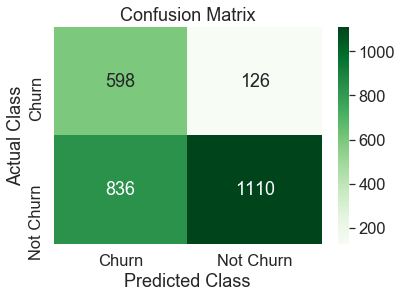

In [30]:
#confusion matrix
cm=confusion_matrix(test[1],preds)
cm
#Plotting Confusion Matrix
class_label = ["Churn", "Not Churn"]
data_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(data_cm, annot = True, fmt = "d", cmap="Greens")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()
sns.set(font_scale=1.5)

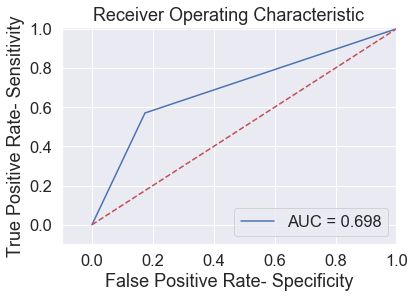

In [31]:
#ROC CURVE
fpr, tpr, thresholds = roc_curve(test[1], preds)

roc_auc = auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate- Sensitivity')
plt.xlabel('False Positive Rate- Specificity')
plt.show()

In [80]:
#repeated temporal holdout evaluation using balanced accuracy measure
total_holdout_sets=10
output_window_size = 21
tumbling_window_size = 7
date= datetime.date(2019,11,19)
date1 = datetime.timedelta(days=output_window_size)
date2= date-date1
date3=datetime.timedelta(days=tumbling_window_size*3)
date4=date2-date3

now = datetime.datetime.strftime(date2, "%Y/%m/%d")
now2=datetime.datetime.strftime(date4, "%Y/%m/%d")

scores = []

model = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=42,
                       verbose=0, warm_start=False)

for i in range(total_holdout_sets):
    test = get_dataset( now , tumbling_window_size, output_window_size )
    train = get_dataset( now2, tumbling_window_size, output_window_size )
    train_scaled=scaler.fit_transform(train[0])
    test_scaled= scaler.fit_transform(test[0])
    X_train,y_train=sm.fit_sample(train_scaled,train[1])
    model.fit( X_train, y_train)
    preds = model.predict(test_scaled)
    
    s= balanced_accuracy_score(test[1], preds)
    scores.append(s)
    date2 = date2- date1
    date4=date4-date3
    
print( np.mean(scores) )
    

0.6930030718913425


In [86]:
#repeated temporal holdout evaluation using f1 score
total_holdout_sets=10
output_window_size = 21
tumbling_window_size = 7
date= datetime.date(2019,11,19)
date1 = datetime.timedelta(days=output_window_size)
date2= date-date1
date3=datetime.timedelta(days=tumbling_window_size*3)
date4=date2-date3

now = datetime.datetime.strftime(date2, "%Y/%m/%d")
now2=datetime.datetime.strftime(date4, "%Y/%m/%d")

scores = []

model = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=42,
                       verbose=0, warm_start=False)

for i in range(total_holdout_sets):
    test = get_dataset( now , tumbling_window_size, output_window_size )
    train = get_dataset( now2, tumbling_window_size, output_window_size )
    train_scaled=scaler.fit_transform(train[0])
    test_scaled= scaler.fit_transform(test[0])
    X_train,y_train=sm.fit_sample(train_scaled,train[1])
    model.fit( X_train, y_train)
    preds = model.predict(test_scaled)
    
    s= f1_score(test[1], preds)
    scores.append(s)
    date2 = date2- date1
    date4=date4-date3
    
print( np.mean(scores) )
    

0.7104316602152232


# KNN

In [32]:
output_window_size = 21
tumbling_window_size = 7
date= datetime.date(2019,11,19)
date1 = datetime.timedelta(days=output_window_size)
date2= date-date1
date3=datetime.timedelta(days=tumbling_window_size*3)
date4=date2-date3

now = datetime.datetime.strftime(date2, "%Y/%m/%d")
now2=datetime.datetime.strftime(date4, "%Y/%m/%d")

test = get_dataset( now , tumbling_window_size, output_window_size )
train = get_dataset( now2, tumbling_window_size, output_window_size )
train_scaled=scaler.fit_transform(train[0])
test_scaled= scaler.fit_transform(test[0])
X_train,y_train=sm.fit_sample(train_scaled,train[1])


In [50]:
#hyperparameter tuning
params = {"n_neighbors": np.arange(1, 31, 2),"metric": ["euclidean", "cityblock", "manhattan"]
        }

knn = KNeighborsClassifier()
randomizedSearch = RandomizedSearchCV(knn, params)
best_model_random= randomizedSearch.fit(X_train,y_train)
print(best_model_random.best_estimator_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=27, p=2,
                     weights='uniform')


In [34]:
#buildng model and making predictions
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=27, p=2,
                     weights='uniform')
knn.fit( X_train, y_train)
preds = knn.predict(test_scaled)

#classification report
print(classification_report(test[1],preds))

              precision    recall  f1-score   support

           0       0.47      0.81      0.60       724
           1       0.91      0.66      0.77      1946

    accuracy                           0.70      2670
   macro avg       0.69      0.74      0.68      2670
weighted avg       0.79      0.70      0.72      2670



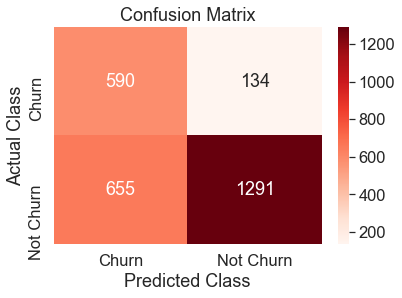

In [35]:
#confusion matrix
cm2=confusion_matrix(test[1],preds)
cm2
#Plotting Confusion Matrix
class_label = ["Churn", "Not Churn"]
data_cm2 = pd.DataFrame(cm2, index = class_label, columns = class_label)
sns.heatmap(data_cm2, annot = True, fmt = "d", cmap="Reds")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()
sns.set(font_scale=1.5)

In [36]:
#calculating auc score
fpr, tpr, thresholds = roc_curve(test[1], preds)

roc_auc = auc(fpr,tpr)
print(roc_auc)

0.7391646272563638


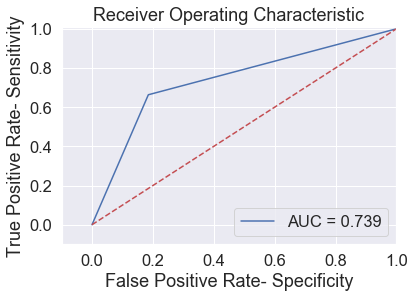

In [37]:
#ROC CURVE
fpr, tpr, thresholds = roc_curve(test[1], preds)

roc_auc = auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate- Sensitivity')
plt.xlabel('False Positive Rate- Specificity')
plt.show()

In [54]:
#temporal holdout evaluation using balanced accuracy
total_holdout_sets=10
output_window_size = 21
tumbling_window_size = 7
date= datetime.date(2019,11,19)
date1 = datetime.timedelta(days=output_window_size)
date2= date-date1
date3=datetime.timedelta(days=tumbling_window_size*3)
date4=date2-date3

now = datetime.datetime.strftime(date2, "%Y/%m/%d")
now2=datetime.datetime.strftime(date4, "%Y/%m/%d")
scores = []

model =  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=27, p=2,
                     weights='uniform')

for i in range(total_holdout_sets):
    test = get_dataset( now , tumbling_window_size, output_window_size )
    train = get_dataset( now2, tumbling_window_size, output_window_size )
    train_scaled=scaler.fit_transform(train[0])
    test_scaled= scaler.fit_transform(test[0])
    X_train,y_train=sm.fit_sample(train_scaled,train[1])
    model.fit( train_scaled, train[1])
    preds = model.predict(test_scaled)
    
    s=balanced_accuracy_score(test[1], preds)
    scores.append(s)
    date2 = date2- date1
    date4=date4-date3

    

print( np.mean(scores) )

0.6588319715182865


In [55]:
#repeated temporal holdout evaluation using f1 score
total_holdout_sets=10
output_window_size = 21
tumbling_window_size = 7
date= datetime.date(2019,11,19)
date1 = datetime.timedelta(days=output_window_size)
date2= date-date1
date3=datetime.timedelta(days=tumbling_window_size*3)
date4=date2-date3

now = datetime.datetime.strftime(date2, "%Y/%m/%d")
now2=datetime.datetime.strftime(date4, "%Y/%m/%d")
scores = []

model =  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=27, p=2,
                     weights='uniform')

for i in range(total_holdout_sets):
    test = get_dataset( now , tumbling_window_size, output_window_size )
    train = get_dataset( now2, tumbling_window_size, output_window_size )
    X_train,y_train=sm.fit_sample(train_scaled,train[1])
    model.fit( train_scaled, train[1])
    preds = model.predict(test_scaled)
    
    s=f1_score(test[1], preds)
    scores.append(s)
    date2 = date2- date1
    date4=date4-date3

    

print( np.mean(scores) )

0.8389809547365819


# SVM

In [38]:
output_window_size = 21
tumbling_window_size = 7
date= datetime.date(2019,11,19)
date1 = datetime.timedelta(days=output_window_size)
date2= date-date1
date3=datetime.timedelta(days=tumbling_window_size*3)
date4=date2-date3

now = datetime.datetime.strftime(date2, "%Y/%m/%d")
now2=datetime.datetime.strftime(date4, "%Y/%m/%d")

test = get_dataset( now , tumbling_window_size, output_window_size )
train = get_dataset( now2, tumbling_window_size, output_window_size )
train_scaled=scaler.fit_transform(train[0])
test_scaled= scaler.fit_transform(test[0])
X_train,y_train=sm.fit_sample(train_scaled,train[1])


In [21]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

svm = svm.SVC()
randomizedSearch = RandomizedSearchCV(svm, param_grid)
best_model_random= randomizedSearch.fit(X_train,y_train)
print(best_model_random.best_estimator_)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [39]:
from sklearn import svm

In [54]:
from sklearn import svm
svm = svm.SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True,
    tol=0.001, verbose=False)
svm.fit( X_train, y_train)
pred_svm = svm.predict(test_scaled)

print(classification_report(test[1],pred_svm))

              precision    recall  f1-score   support

           0       0.50      0.77      0.61       724
           1       0.89      0.72      0.80      1946

    accuracy                           0.73      2670
   macro avg       0.70      0.74      0.70      2670
weighted avg       0.79      0.73      0.74      2670



In [55]:
#calculating auc score
fpr, tpr, thresholds = roc_curve(test[1], pred_svm)

roc_auc = auc(fpr,tpr)
print(roc_auc)

0.7426623815391254


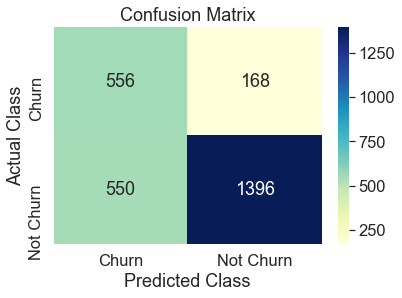

In [56]:
#confusion matrix
cm1=confusion_matrix(test[1],pred_svm)
cm1
#Plotting Confusion Matrix
class_label = ["Churn", "Not Churn"]
data_cm1 = pd.DataFrame(cm1, index = class_label, columns = class_label)
sns.heatmap(data_cm1, annot = True, fmt = "d", cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()
sns.set(font_scale=1.5)

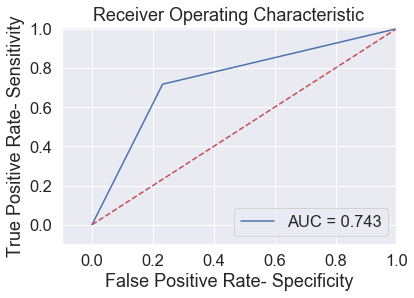

In [57]:
#ROC CURVE
fpr, tpr, thresholds = roc_curve(test[1], pred_svm)

roc_auc = auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate- Sensitivity')
plt.xlabel('False Positive Rate- Specificity')
plt.show()

In [78]:
from sklearn import svm
total_holdout_sets=10
output_window_size = 21
tumbling_window_size = 7
date= datetime.date(2019,11,19)
date1 = datetime.timedelta(days=output_window_size)
date2= date-date1
date3=datetime.timedelta(days=tumbling_window_size*3)
date4=date2-date3

now = datetime.datetime.strftime(date2, "%Y/%m/%d")
now2=datetime.datetime.strftime(date4, "%Y/%m/%d")
scores = []

model =  svm.SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True,
    tol=0.001, verbose=False)

for i in range(total_holdout_sets):
    test = get_dataset( now , tumbling_window_size, output_window_size )
    train = get_dataset( now2, tumbling_window_size, output_window_size )
    X_train,y_train=sm.fit_sample(train_scaled,train[1])
    model.fit( train_scaled, train[1])
    preds = model.predict(test_scaled)
    
    s= balanced_accuracy_score(test[1], preds)
    scores.append(s)
    date2 = date2- date1
    date4=date4-date3

    

print( np.mean(scores) )

0.6933964272938397


In [42]:
###
from sklearn import svm
total_holdout_sets=10
output_window_size = 21
tumbling_window_size = 7
date= datetime.date(2019,11,19)
date1 = datetime.timedelta(days=output_window_size)
date2= date-date1
date3=datetime.timedelta(days=tumbling_window_size*3)
date4=date2-date3

now = datetime.datetime.strftime(date2, "%Y/%m/%d")
now2=datetime.datetime.strftime(date4, "%Y/%m/%d")
scores = []

model =  svm.SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True,
    tol=0.001, verbose=False)

for i in range(total_holdout_sets):
    test = get_dataset( now , tumbling_window_size, output_window_size )
    train = get_dataset( now2, tumbling_window_size, output_window_size )
    X_train,y_train=sm.fit_sample(train_scaled,train[1])
    model.fit( train_scaled, train[1])
    preds = model.predict(test_scaled)
    
    s= balanced_accuracy_score(test[1], preds)
    scores.append(s)
    date2 = date2- date1
    date4=date4-date3

    

print( np.mean(scores) )

0.6933964272938397


In [88]:
from sklearn import svm
total_holdout_sets=10
output_window_size = 21
tumbling_window_size = 7
date= datetime.date(2019,11,19)
date1 = datetime.timedelta(days=output_window_size)
date2= date-date1
date3=datetime.timedelta(days=tumbling_window_size*3)
date4=date2-date3

now = datetime.datetime.strftime(date2, "%Y/%m/%d")
now2=datetime.datetime.strftime(date4, "%Y/%m/%d")
scores = []

model =  svm.SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True,
    tol=0.001, verbose=False)

for i in range(total_holdout_sets):
    test = get_dataset( now , tumbling_window_size, output_window_size )
    train = get_dataset( now2, tumbling_window_size, output_window_size )
    X_train,y_train=sm.fit_sample(train_scaled,train[1])
    model.fit( train_scaled, train[1])
    preds = model.predict(test_scaled)
    
    s= f1_score(test[1], preds)
    scores.append(s)
    date2 = date2- date1
    date4=date4-date3

    

print( np.mean(scores) )

0.8369120654396728


In [43]:
####
from sklearn import svm
total_holdout_sets=10
output_window_size = 21
tumbling_window_size = 7
date= datetime.date(2019,11,19)
date1 = datetime.timedelta(days=output_window_size)
date2= date-date1
date3=datetime.timedelta(days=tumbling_window_size*3)
date4=date2-date3

now = datetime.datetime.strftime(date2, "%Y/%m/%d")
now2=datetime.datetime.strftime(date4, "%Y/%m/%d")
scores = []

model =  svm.SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True,
    tol=0.001, verbose=False)

for i in range(total_holdout_sets):
    test = get_dataset( now , tumbling_window_size, output_window_size )
    train = get_dataset( now2, tumbling_window_size, output_window_size )
    X_train,y_train=sm.fit_sample(train_scaled,train[1])
    model.fit( train_scaled, train[1])
    preds = model.predict(test_scaled)
    
    s= f1_score(test[1], preds)
    scores.append(s)
    date2 = date2- date1
    date4=date4-date3

    

print( np.mean(scores) )

0.8369120654396728


# Logistic Regression

In [58]:
#hyperparameter tuning
param_grid ={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
lr=LogisticRegression()
randomizedSearch = RandomizedSearchCV(lr, param_grid)
best_model_random= randomizedSearch.fit(X_train,y_train)
print(best_model_random.best_estimator_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [60]:
#building the model and making predictions
model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
model.fit( X_train, y_train )
pred_lr = model.predict(test_scaled)
print(classification_report(test[1],pred_lr))

              precision    recall  f1-score   support

           0       0.46      0.84      0.60       724
           1       0.92      0.64      0.75      1946

    accuracy                           0.69      2670
   macro avg       0.69      0.74      0.67      2670
weighted avg       0.79      0.69      0.71      2670



In [61]:
#calculating auc score
fpr, tpr, thresholds = roc_curve(test[1], pred_lr)

roc_auc = auc(fpr,tpr)
print(roc_auc)

0.740049712400561


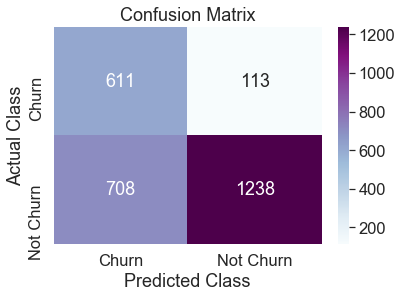

In [64]:
#confusion matrix
cm3=confusion_matrix(test[1],pred_lr)
cm3
#Plotting Confusion Matrix
class_label = ["Churn", "Not Churn"]
data_cm3 = pd.DataFrame(cm3, index = class_label, columns = class_label)
sns.heatmap(data_cm3, annot = True, fmt = "d", cmap="BuPu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()
sns.set(font_scale=1.5)

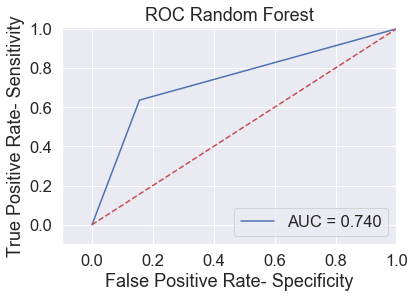

In [63]:
#ROC CURVE
fpr, tpr, thresholds = roc_curve(test[1], pred_lr)

roc_auc = auc(fpr,tpr)
plt.title('ROC Random Forest')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate- Sensitivity')
plt.xlabel('False Positive Rate- Specificity')
plt.show()

In [77]:
#temporal holdout evaluation using balanced accuracy
total_holdout_sets=10
output_window_size = 21
tumbling_window_size = 7
date= datetime.date(2019,11,19)
date1 = datetime.timedelta(days=output_window_size)
date2= date-date1
date3=datetime.timedelta(days=tumbling_window_size*3)
date4=date2-date3

now = datetime.datetime.strftime(date2, "%Y/%m/%d")
now2=datetime.datetime.strftime(date4, "%Y/%m/%d")
scores = []

model =  LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

for i in range(total_holdout_sets):
    test = get_dataset( now , tumbling_window_size, output_window_size )
    train = get_dataset( now2, tumbling_window_size, output_window_size )
    X_train,y_train=sm.fit_sample(train_scaled,train[1])
    model.fit( train_scaled, train[1])
    preds = model.predict(test_scaled)
    
    s=balanced_accuracy_score(test[1], preds)
    scores.append(s)
    date2 = date2- date1
    date4=date4-date3

    

print( np.mean(scores) )

0.6949870253757531


In [45]:
#temporal holdout evaluation using f1 score
total_holdout_sets=10
output_window_size = 21
tumbling_window_size = 7
date= datetime.date(2019,11,19)
date1 = datetime.timedelta(days=output_window_size)
date2= date-date1
date3=datetime.timedelta(days=tumbling_window_size*3)
date4=date2-date3

now = datetime.datetime.strftime(date2, "%Y/%m/%d")
now2=datetime.datetime.strftime(date4, "%Y/%m/%d")
scores = []

model =  LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

for i in range(total_holdout_sets):
    test = get_dataset( now , tumbling_window_size, output_window_size )
    train = get_dataset( now2, tumbling_window_size, output_window_size )
    X_train,y_train=sm.fit_sample(train_scaled,train[1])
    model.fit( train_scaled, train[1])
    preds = model.predict(test_scaled)
    
    s=f1_score(test[1], preds)
    scores.append(s)
    date2 = date2- date1
    date4=date4-date3

    

print( np.mean(scores) )

0.8334620334620336


# Customer Insights

In [5]:
#importing csv file generate from SQL code:

#CREATE VIEW ucd_data AS
#SELECT customer_id, store_code, department_name, sum(qty) as "qty", sum(value) as "value"
#FROM ml17.receipts
#JOIN ml17.receipt_lines
#USING(receipt_id)
#JOIN ml17.products
#USING(product_code)
#WHERE purchased_at<= '2019-10-29' and purchased_at>= '2019-10-21'
#GROUP BY 1,2,3

ucd_data=pd.read_csv("ucd_data.csv")

In [6]:
ucd_data.head()

,customer_id,store_code,department_name,qty,value
0,1,0,BEVERAGES,5,12.66
1,1,0,GROCERY 3,6,8.65
2,1,1,BAKERY,4,2.79
3,1,1,BEVERAGES,1,2.55
4,1,1,FRUIT & VEGETABLES,2,2.88


In [112]:
#extracting data related to visits, qty and value.
def get_df( reference_day = '2019-10-29', tumbling_window_size = 21, output_window_size = 21 ):
    sql = """
    SELECT customer_id, ref_day, output_feature, visits_t1, visits_t2, visits_t3, visits_t4, qty_t1, qty_t2, qty_t3, qty_t4, value_t1, value_t2, value_t3, value_t4 
    FROM(
        SELECT customer_id, 
           %(ref_date)s::DATE AS ref_day,
           SUM( DISTINCT CASE WHEN purchased_at > %(ref_date)s::DATE AND purchased_at <= %(ref_date)s::DATE + %(ows)s::INT THEN 1 ELSE 0 END) as output_feature,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT AND purchased_at <= %(ref_date)s::DATE THEN 1 ELSE 0 END ) as visits_t1,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*2 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT THEN 1 ELSE 0 END ) as visits_t2,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*3 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*2 THEN 1 ELSE 0 END ) as visits_t3,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*4 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*3 THEN 1 ELSE 0 END ) as visits_t4,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT AND purchased_at <= %(ref_date)s::DATE THEN qty ELSE 0 END ) as qty_t1,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*2 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT THEN qty ELSE 0 END ) as qty_t2,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*3 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*2 THEN qty ELSE 0 END ) as qty_t3,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*4 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*3 THEN qty ELSE 0 END ) as qty_t4,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT AND purchased_at <= %(ref_date)s::DATE THEN value ELSE 0 END ) as value_t1,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*2 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT THEN value ELSE 0 END ) as value_t2,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*3 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*2 THEN value ELSE 0 END ) as value_t3,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*4 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*3 THEN value ELSE 0 END ) as value_t4
    FROM data
    GROUP BY 1
    ORDER BY 1) X
    WHERE visits_t1 > 0 or visits_t2>0 or visits_t3>0
    """
    with psycopg2.connect("host='{}' dbname='nlab' user='{}' password='{}'".format(host, username, password)) as conn:
        df = pd.read_sql(sql, conn, params = {'ref_date':reference_day, 'ws':tumbling_window_size, 'ows':output_window_size})

    return df.drop(columns = ['ref_day','output_feature'], inplace = False), df.output_feature

In [113]:
data1 = get_df( now , tumbling_window_size, output_window_size )
data1 = data1[0].assign(churn=data1[1])
data1

,customer_id,visits_t1,visits_t2,visits_t3,visits_t4,qty_t1,qty_t2,qty_t3,qty_t4,value_t1,value_t2,value_t3,value_t4,churn
0,1,0,1,1,0,0.0,14.0,4.0,0.0,0.00,17.56,8.01,0.00,1
1,4,0,1,0,1,0.0,8.0,0.0,21.0,0.00,15.25,0.00,19.84,1
2,25,0,2,2,0,0.0,18.0,20.0,0.0,0.00,13.04,29.24,0.00,1
3,39,4,2,5,6,38.0,31.0,47.0,82.0,52.74,35.50,77.43,114.80,1
4,41,1,1,1,0,28.0,21.0,28.0,0.0,49.78,43.57,49.78,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2665,16302,2,2,1,1,25.0,41.0,21.0,26.0,19.50,35.10,25.19,24.71,1
2666,16310,1,1,1,1,16.0,8.0,5.0,5.0,8.36,4.01,5.86,5.55,1
2667,16312,1,1,1,0,10.0,5.0,12.0,0.0,8.98,6.58,19.24,0.00,1
2668,16322,0,0,1,0,0.0,0.0,1.0,0.0,0.00,0.00,3.85,0.00,0


In [493]:
#conveting dataframe to excel file to be used in tableau
data1.to_excel('data1.xlsx', index=False)

In [114]:
#making seperate dataframes from churners and non churners
churners= data1[data1.churn==0]
non_churners= data1[data1.churn==1]

In [472]:
#creating files into excel format to be used in tableau

churners.to_excel('churners.xlsx', index=False)
non_churners.to_excel('non_churners.xlsx', index=False)

In [115]:
churners.describe()

,customer_id,visits_t1,visits_t2,visits_t3,visits_t4,qty_t1,qty_t2,qty_t3,qty_t4,value_t1,value_t2,value_t3,value_t4,churn
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.0
mean,8354.341160,0.400552,0.459945,0.406077,0.203039,4.259669,5.410221,4.596685,2.263812,5.979931,7.824779,6.945028,2.968163,0.0
std,4660.179534,0.538734,0.594859,0.552391,0.460250,8.848907,11.344058,9.978693,6.767898,12.262964,15.105998,14.940955,8.721892,0.0
min,47.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,4466.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,8397.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,12410.000000,1.000000,1.000000,1.000000,0.000000,5.000000,6.000000,5.000000,0.000000,7.602500,9.790000,8.747500,0.000000,0.0
max,16322.000000,2.000000,6.000000,5.000000,4.000000,73.000000,98.000000,86.000000,74.000000,94.470000,132.460000,137.950000,76.620000,0.0


In [116]:
non_churners.describe()

,customer_id,visits_t1,visits_t2,visits_t3,visits_t4,qty_t1,qty_t2,qty_t3,qty_t4,value_t1,value_t2,value_t3,value_t4,churn
count,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.0
mean,8221.213258,0.937821,0.917780,0.943474,0.874615,9.972251,10.155704,10.180884,9.699897,13.196346,13.852138,13.276819,12.653710,1.0
std,4694.311536,1.013400,0.938424,0.998143,0.997015,14.401737,14.772757,13.399158,14.803577,18.318185,21.499800,16.710819,18.117966,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,4151.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,8253.500000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,4.500000,7.510000,8.070000,7.730000,6.705000,1.0
75%,12226.500000,1.000000,1.000000,1.000000,1.000000,14.750000,14.000000,15.000000,14.000000,19.195000,19.537500,19.842500,18.500000,1.0
max,16325.000000,7.000000,7.000000,7.000000,7.000000,160.000000,191.000000,102.000000,180.000000,173.060000,479.120000,147.800000,205.740000,1.0


In [72]:
#merging customer data with data1
new_data1=data1.merge(ucd_data, how='outer', left_on='customer_id', right_on='customer_id')


In [ ]:
#converting dataframe to excel file to be used in tableau
new_data1.to_excel('new_data1.xlsx', index=False)

In [73]:
new_data1.describe()

,customer_id,visits_t1,visits_t2,visits_t3,visits_t4,qty_t1,qty_t2,qty_t3,qty_t4,value_t1,value_t2,value_t3,value_t4,churn,store_code,qty,value
count,19335.000000,16061.000000,16061.000000,16061.000000,16061.000000,16061.000000,16061.000000,16061.000000,16061.000000,16061.000000,16061.000000,16061.000000,16061.000000,16061.000000,18665.000000,18665.000000,18665.000000
mean,8153.128679,1.063072,1.015690,1.036112,0.978457,11.981010,11.770375,11.737314,11.619575,15.322822,15.502217,14.801437,14.774338,0.941722,1.387945,3.795982,5.133063
std,4663.084862,1.107461,1.021867,1.094963,1.078505,16.052683,15.971942,14.584338,16.982031,19.813437,20.666509,17.644456,20.286069,0.234275,0.689532,4.657131,7.932474
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.010000
25%,4120.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.350000
50%,8144.000000,1.000000,1.000000,1.000000,1.000000,7.000000,7.000000,7.000000,6.000000,9.510000,9.610000,9.230000,8.670000,1.000000,1.000000,2.000000,2.870000
75%,12072.000000,1.000000,1.000000,1.000000,1.000000,17.000000,17.000000,18.000000,17.000000,21.920000,21.770000,22.610000,22.100000,1.000000,2.000000,4.000000,5.880000
max,16326.000000,7.000000,7.000000,7.000000,7.000000,160.000000,191.000000,102.000000,180.000000,173.060000,479.120000,147.800000,205.740000,1.000000,3.000000,80.000000,209.190000


# Churn Model

In [3]:
#extracting data from the sql server
#This set of command makes variables f1-f8 
#f1-f4 are the number of visits of customers
#f5-f8 are the quantities bought by customers

#you can insert the reference day as per the latest available data
def get_dataset( reference_day = '2019-11-09', tumbling_window_size = 7, output_window_size = 21 ):
    sql = """
    SELECT customer_id, ref_day, output_feature, f1, f2, f3, f4, f5, f6, f7, f8
    FROM(
        SELECT customer_id,
           %(ref_date)s::DATE AS ref_day,
           SUM( DISTINCT CASE WHEN purchased_at > %(ref_date)s::DATE AND purchased_at <= %(ref_date)s::DATE + %(ows)s::INT THEN 1 ELSE 0 END) as output_feature,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT AND purchased_at <= %(ref_date)s::DATE THEN 1 ELSE 0 END ) as f1,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*2 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT THEN 1 ELSE 0 END ) as f2,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*3 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*2 THEN 1 ELSE 0 END ) as f3,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*4 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*3 THEN 1 ELSE 0 END ) as f4,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT AND purchased_at <= %(ref_date)s::DATE THEN qty ELSE 0 END ) as f5,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*2 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT THEN qty ELSE 0 END ) as f6,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*3 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*2 THEN qty ELSE 0 END ) as f7,
           SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s::INT*4 AND purchased_at <= %(ref_date)s::DATE -%(ws)s::INT*3 THEN qty ELSE 0 END ) as f8
    FROM data
    GROUP BY 1
    ORDER BY 1) X
    WHERE f1 > 0 or f2>0 or f3>0
    """
    with psycopg2.connect("host='{}' dbname='nlab' user='{}' password='{}'".format(host, username, password)) as conn:
        df = pd.read_sql(sql, conn, params = {'ref_date':reference_day, 'ws':tumbling_window_size, 'ows':output_window_size})

    return df.drop(columns = ['ref_day','output_feature', 'customer_id'], inplace = False), df.output_feature

In [4]:
# defining the tumbling and output window size
tumbling_window_size=7
output_window_size=21

# dates can be set acording to the latest available date from the data 
date= datetime.date(2019,11,19)
date1 = datetime.timedelta(days=output_window_size)
date2= date-date1

now = datetime.datetime.strftime(date2, "%Y/%m/%d")


#using the latest data for the train set
x, y = get_dataset( now , tumbling_window_size, output_window_size )

In [10]:
#Scaling the input variables of the data
scaler=StandardScaler()
x=preprocessing.scale(x)

In [12]:
#training the final model
from sklearn import svm
svm = svm.SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True,
    tol=0.001, verbose=False)
svm.fit(x, y)

#making predictions
pred_svm = svm.predict(x)

